In [9]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import torch
import shutil
import sys
import random
from joblib import Parallel, delayed
from IPython.display import display, HTML
from matplotlib import animation, rc
from pathlib import Path
import seaborn as sns
from sklearn.cluster import KMeans
sys.path.append('../input/tensorflow-great-barrier-reef')
rc('animation', html='jshtml')
%matplotlib inline

In [10]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

In [14]:
CONF = 0.15

def process_pred(x):
    if isinstance(x, list):
        pred = []
        x = np.array(x).reshape(-1, 5).astype("float")
        for idx in range(len(x)):
            if x[idx, 0] > CONF:
                pred.append(x[idx, 1:].tolist())
        return pred
    return []

In [19]:
def calc_iou(bboxes1, bboxes2, bbox_mode='xywh'):
    # xmin ymin weight height
    assert len(bboxes1.shape) == 2 and bboxes1.shape[1] == 4
    assert len(bboxes2.shape) == 2 and bboxes2.shape[1] == 4
    
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    if bbox_mode == 'xywh':
        bboxes1[:, 2:] += bboxes1[:, :2]
        bboxes2[:, 2:] += bboxes2[:, :2]

    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [20]:
from tqdm import tqdm

IOU = 0.2
def gr_track_analysis(gts, preds):
    gt_track = []
    cache = []
    cnt = 0
    for step, (gt, pred) in tqdm(enumerate(zip(gts, preds)), total=len(gts)):
        gt = np.array(gt)
        pred = np.array(pred)
        
        # not gt in current and last frame
        if (len(gt) == 0) and (len(cache) == 0):
            continue
        
        # No new gt
        if len(gt) == 0:
            gt_track.extend([cache.pop() for _ in range(len(cache))])
            continue
        
        # No old gt
        if len(cache) == 0:
            for idx in range(len(gt)):
                cache.append([gt[idx], []])
        else:
            last_gt_iou = calc_iou(np.array([b for b,_ in cache]), gt)

            # update gt bbox coordinate
            keep_gt = np.where(np.max(last_gt_iou, 1) >= IOU)[0].tolist()
            update  = np.argmax(last_gt_iou, 1)[keep_gt].tolist()

            for keep_idx, update_idx in zip(keep_gt, update):
                cache[keep_idx][0] = gt[update_idx]

            # drop missing gt bbox
            new_cache = []
            for i in range(len(cache)):
                c = cache[i].copy()
                if i in keep_gt:
                    new_cache.append(c)
                else:
                    gt_track.append(c)
            cache = new_cache

            # add new gt bbox
            new_gt = np.where(np.max(last_gt_iou, 0) < IOU)[0].tolist()
            for new in new_gt:
                cache.append([gt[new], []])
        
        # update track
        
        if len(pred) == 0:
            for i in range(len(cache)):
                cache[i][1].append(0)
            continue
        
        
        track_iou = calc_iou(np.array([b for b,_ in cache]), pred)
        for idx, (iou, _) in enumerate(zip(np.max(track_iou, 1), np.max(track_iou, 1))):
            if iou >= 0.4:
                cache[idx][1].append(1)
            else:
                cache[idx][1].append(0)
    
    gt_track.extend([cache.pop() for _ in range(len(cache))])
    return gt_track

In [39]:
def model_correlation(model_dict):
    record = {}
    
    for name, path in model_dict.items():
        df = pd.read_csv(path)
        df['annotations'] = df['annotations'].apply(eval).apply(get_bbox)
        df['preds'] = df['preds'].str.split(" ").apply(process_pred)
        df_track = gr_track_analysis(df.annotations, df.preds)
        df_track = np.array([np.mean(j) for i,j in df_track])
        record[name] = df_track
    
    return pd.DataFrame(record)

In [40]:
models = {
    "s1": "./stage_cache/single_model/m1/m1_sz3600_nmsconf0.01_nmsiou0.2.csv",
    "s2": "./stage_cache/single_model/m1/m1_sz2988_nmsconf0.01_nmsiou0.2.csv",
    "s3": "./stage_cache/single_model/m1/m1_sz2412_nmsconf0.01_nmsiou0.2.csv",
    "s4": "./stage_cache/single_model/m1/m1_sz9000_nmsconf0.01_nmsiou0.2.csv",
    "s5": "./stage_cache/single_model/m1/m1_sz7500_nmsconf0.01_nmsiou0.2.csv",
    "s6": "./stage_cache/single_model/m1/m1_sz6000_nmsconf0.01_nmsiou0.2.csv",
    "s7": "./stage_cache/single_model/m1/m1_sz4980_nmsconf0.01_nmsiou0.2.csv",
    "s8": "./stage_cache/single_model/m1/m1_sz4020_nmsconf0.01_nmsiou0.2.csv",
    "s9": "./stage_cache/single_model/m4/m4_sz9000_nmsconf0.01_nmsiou0.2.csv",
    "s10": "./stage_cache/single_model/m4/m4_sz7500_nmsconf0.01_nmsiou0.2.csv",
    "s11": "./stage_cache/single_model/m4/m4_sz6000_nmsconf0.01_nmsiou0.2.csv",
    "s12": "./stage_cache/single_model/m4/m4_sz4980_nmsconf0.01_nmsiou0.2.csv",
    "s13": "./stage_cache/single_model/m4/m4_sz4020_nmsconf0.01_nmsiou0.2.csv",
    "s14": "./stage_cache/single_model/m4/m4_sz3600_nmsconf0.01_nmsiou0.2.csv",
    "s15": "./stage_cache/single_model/m4/m4_sz2988_nmsconf0.01_nmsiou0.2.csv",
    "s16": "./stage_cache/single_model/m4/m4_sz2412_nmsconf0.01_nmsiou0.2.csv",
    "s17": "./stage_cache/single_model/m3/m3_sz3000_nmsconf0.01_nmsiou0.2.csv",
    "s18": "./stage_cache/single_model/m3/m3_sz2400_nmsconf0.01_nmsiou0.2.csv",
    "s19": "./stage_cache/single_model/m3/m3_sz1980_nmsconf0.01_nmsiou0.2.csv",
    "s20": "./stage_cache/single_model/m3/m3_sz1280_nmsconf0.01_nmsiou0.2.csv",
}

In [41]:
corr = model_correlation(models)

100%|██████████████████████████████████| 23501/23501 [00:00<00:00, 31728.51it/s]


<AxesSubplot:>

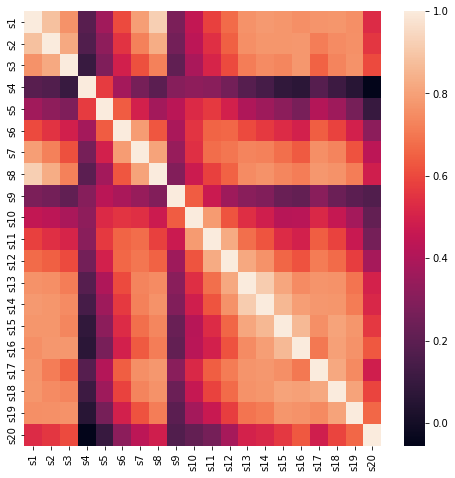

In [48]:
plt.figure(figsize=(8, 8))
sns.heatmap(corr.corr())

In [50]:
corr.corr().mean()

s1     0.669046
s2     0.650879
s3     0.611397
s4     0.241259
s5     0.426984
s6     0.578091
s7     0.651791
s8     0.658169
s9     0.346059
s10    0.508034
s11    0.588308
s12    0.633970
s13    0.671107
s14    0.667124
s15    0.644520
s16    0.626459
s17    0.656199
s18    0.654954
s19    0.609252
s20    0.446755
dtype: float64

Text(0.5, 1.0, 'Track hit ratio')

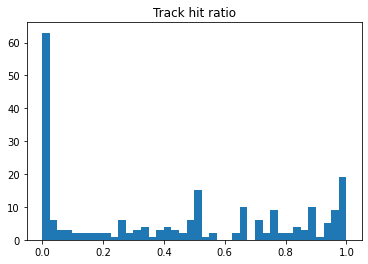

In [273]:
track_ratio = np.array([np.mean(t[1]) for t in gt_track])
_ = plt.hist(track_ratio, bins=40)
plt.title("Track hit ratio")

Text(0.5, 1.0, 'Track lens')

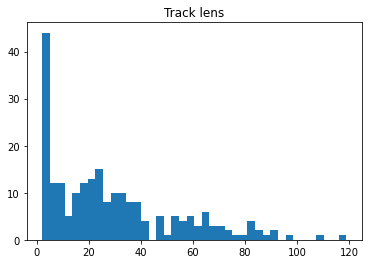

In [274]:
track_lens  =  np.array([len(t[1]) for t in gt_track])
_ = plt.hist(track_lens, bins=40)
plt.title("Track lens")

In [275]:
# over all FP / (FP + FN)

np.sum(track_ratio * track_lens) / np.sum(track_lens)

0.5157076205287714

Text(0.5, 1.0, 'miss track after hit')

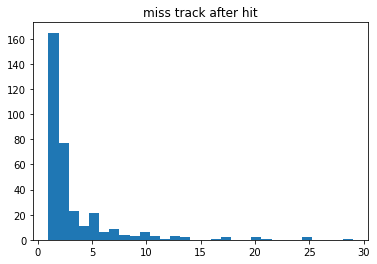

In [316]:
# miss track after hit

miss_cnt = []

for t in track:
    TRACK = False
    cnt   = 0
    for h in t:
        if (TRACK & (h == 0)) or ((cnt > 0) & (h == 0)):
            cnt += 1
        if h == 1:
            TRACK = True
            if cnt > 0:
                miss_cnt.append(cnt)
            cnt = 0
    if cnt > 0:
        miss_cnt.append(cnt)
        
_ = plt.hist(miss_cnt, 30)
plt.title("miss track after hit")

In [278]:
bbox = np.array([t[0] for t in gt_track])
area = bbox[:, 2] * bbox[:, 3]

In [304]:
cluster5 = KMeans(5).fit_predict(bbox)

In [318]:
pd.DataFrame({"cluster": cluster5, "hit_mean": track_ratio}).groupby("cluster")['hit_mean'].mean()

cluster
0    0.288447
1    0.583873
2    0.443381
3    0.566393
4    0.285976
Name: hit_mean, dtype: float64

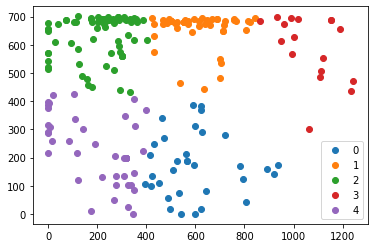

In [340]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in np.unique(cluster5):
    plt.scatter(bbox[cluster5==i,0], bbox[cluster5==i,1], c=colors[i], label=i)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Area vs Hit Ratio')

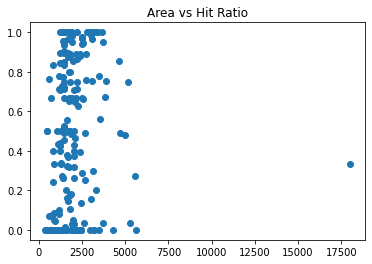

In [281]:
plt.scatter(area, track_ratio)
plt.title("Area vs Hit Ratio")

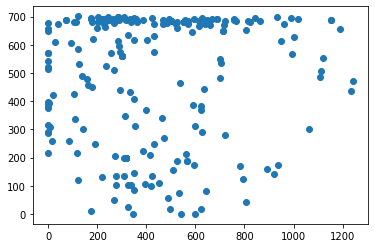

In [290]:
plt.scatter(bbox[:,0], bbox[:,1])

/home/kky/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

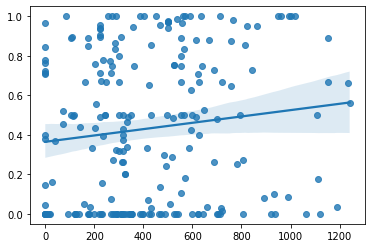

In [289]:
sns.regplot(bbox[:, 0], track_ratio)

/home/kky/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

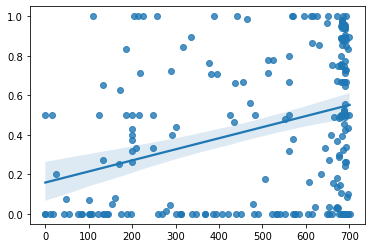

In [288]:
sns.regplot(bbox[:, 1], track_ratio)

In [296]:
track = [t[1] for t in gt_track]
first_hit = [t.index(1) if 1 in t else -1 for t in track]

In [300]:
# first hit location

pd.Series(first_hit).value_counts().sort_index()

-1     62
 0     58
 1     29
 2      4
 3      9
 4      7
 5      3
 6      2
 7      4
 8      3
 9      5
 10     1
 11     3
 12     2
 13     4
 14     2
 15     2
 16     3
 17     2
 18     1
 19     1
 20     1
 24     3
 26     2
 29     1
 31     1
 35     1
 42     2
 45     1
 57     1
 59     1
 65     1
dtype: int64